Land cover mapping using machine learning and NAIP
=======================================


## Introduction
In this lab we will classify the NAIP images using machine learning. We will work on data preparation and then use traditional machine learning for the image classification. It is a great first step into the world of machine learning for classification in remote sensing.


## scikit-learn
 `scikit-learn` is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces.

## Preparing the dataset

Download the lu_phily data from here [link](https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/lu_phily.tif)

Download the NAIP here [link](https://utilitiesfiles.s3.us-east-1.amazonaws.com/penn-class/ai-urban-sustainability/data/naip-philly.tif)


In [3]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

## 1. Prepare the dataset for training
We need to pair the NAIP image and label to build the training dataset. In this tutorial, I just use  the existing land cover map in Philadlephia to generate the land cover map and test the accuracy of the image classification method. 

In [4]:
naipfile = '../naip-philly.tif'
naip_dataset = rasterio.open(naipfile)
img_rows, img_cols = naip_dataset.shape
img_bands = naip_dataset.count

print(naip_dataset.shape) # dimensions
print(naip_dataset.count) # bands

lu_dataset = rio.open('../lu_phily.tif')

print(lu_dataset.shape)


(30506, 27280)
4
(50146, 44770)


In [5]:
naip_dataset.meta, lu_dataset.meta

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': None,
  'width': 27280,
  'height': 30506,
  'count': 4,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660575.1551,
         0.0, -3.2821119058545856, 304939.8064)},
 {'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 44770,
  'height': 50146,
  'count': 1,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(2.0, 0.0, 2660573.4998999997,
         0.0, -2.0, 304943.1693)})

Affine(a, b, c,
       d, e, f)
    1. a → Pixel width (resolution in X direction)
	•	b → Row rotation (usually 0 unless rotated)
	•	c → X-coordinate of the top-left corner (origin)
	•	d → Column rotation (usually 0 unless rotated)
	•	e → Pixel height (negative for North-up images)
	•	f → Y-coordinate of the top-left corner (origin)

### The two datasets have different resolution and dimension. We cannot directly pair them together. We need to do several steps of data cleanning, like resampling.

### 1.1 Resample the raster data to the same spatial resolution
The two raster data have different spatial resolution. Therefore, we'd better to do a resampleing, make sure they have the same spatial resolution. 

#### 1.1.1 Read the raster datasets

In [6]:
import rasterio
from rasterio.enums import Resampling

naipfile = '../naip-philly.tif'
lufile = '../lu_phily.tif'

# Define file paths, here we resample the lu file with the NAIP imagery
source_raster = lufile  # The raster to be resampled
target_raster = naipfile  # The reference raster (desired resolution)
output_raster = "../lu_resample.tif"  # The output file

# Open the reference raster to get its transform and resolution
ref = rasterio.open(target_raster) 
target_transform = ref.transform
target_crs = ref.crs
target_res = ref.res  # Resolution (pixel size)
target_width = ref.width
target_height = ref.height
target_crs, target_transform

(CRS.from_epsg(2272),
 Affine(3.282111906158346, 0.0, 2660575.1551,
        0.0, -3.2821119058545856, 304939.8064))

#### 1.1.2. Resample the lu to the same as the NAIP

In [7]:
# Open the source raster to resample
src= rasterio.open(source_raster)
# Read source data
src_data = src.read(1)  # Read the first band
source_transform = src.transform

# # Define the new transform and size based on the target raster
# new_transform = target_transform
# Update the transform with new resolution but keep the same extent
new_transform = rasterio.transform.Affine(
    target_res[0], source_transform.b, source_transform.c,
    source_transform.d, -target_res[1], source_transform.f
)

# Compute new raster size (preserve extent, only change resolution)
new_width = int((src.width * src.res[0]) / target_res[0])
new_height = int((src.height * src.res[1]) / target_res[1])

# Perform resampling
resampled_data = src.read(
    out_shape=(1, new_height, new_width),  # Match target shape
    resampling= Resampling.nearest# Resampling.bilinear  # Choose resampling method, we 
)

## to make sure the resample geotiff also colorful
color_interpretation = src.colorinterp
colormap = src.colormap(1)  # Extract color table (only for 1-band rasters)

# Update metadata for the output raster
new_meta = src.meta.copy()
new_meta.update({
    "driver": "GTiff",
    "height": new_height,
    "width": new_width,
    "transform": new_transform,
    "crs": target_crs,  # Match CRS,
    "count": 1,  # Ensure single band
    "compress": 'lzw'
})


#### 1.1.3. Save the result as a geotiff

In [8]:
# Save the resampled raster
with rasterio.open(output_raster, "w", **new_meta) as dst:
    dst.write(resampled_data)
    
    # just to write the color scheme, make sure the output tiff also has color, from chatgpt
    dst.colorinterp = color_interpretation
    dst.write_colormap(1, colormap)  # Apply original colormap
    
print("Resampling completed successfully!")

Resampling completed successfully!


### 1.2 Find the common region of LU and NAIP
The two datasets may have different bounds, although they both cover whole Philly. Therefore, we need to clip a common region to make sure the NAIP and land use map are paired. 

#### 1.2.1 Use the resampled land use map and check the bounds of two datasets

In [9]:
lu_dataset = rio.open('../lu_resample.tif')

naip_res = naip_dataset.res
lu_res = lu_dataset.res

naip_bounds = naip_dataset.bounds
lulc_bounds = lu_dataset.bounds
naip_res, lu_res, naip_bounds, lulc_bounds

((3.282111906158346, 3.2821119058545856),
 (3.282111906158346, 3.2821119058545856),
 BoundingBox(left=2660575.1551, bottom=204815.7006, right=2750111.1679, top=304939.8064),
 BoundingBox(left=2660573.4998999997, bottom=204651.67579280143, right=2750112.7948119054, top=304943.1693))

In [10]:
lu_dataset.shape, naip_dataset.shape

((30557, 27281), (30506, 27280))

#### The two raster have different size and bounds. Therefore, we are going to use the coordinates of pixels to match pixels of land use and naip in a common region. 

Let's find the bounding box of the common region first.

In [11]:
from rasterio.coords import BoundingBox

# Find intersection (common area)
common_bounds = BoundingBox(
    max(lulc_bounds.left, naip_bounds.left),
    max(lulc_bounds.bottom, naip_bounds.bottom),
    min(lulc_bounds.right, naip_bounds.right),
    min(lulc_bounds.top, naip_bounds.top),
)

print("\nCommon Bounds (Overlapping Area):", common_bounds)



Common Bounds (Overlapping Area): BoundingBox(left=2660575.1551, bottom=204815.7006, right=2750111.1679, top=304939.8064)


In [12]:
from rasterio.mask import mask


def clip_raster(input_raster, output_raster, common_bounds, reference_crs):
    with rasterio.open(input_raster) as src:
        # Ensure bounds are in the same CRS
        src_crs = src.crs
        if src_crs != reference_crs:
            aligned_bounds = transform_bounds(reference_crs, src_crs,
                                              common_bounds.left, common_bounds.bottom,
                                              common_bounds.right, common_bounds.top)
        else:
            aligned_bounds = (common_bounds.left, common_bounds.bottom, common_bounds.right, common_bounds.top)

        # Preserve color interpretation and colormap (for LU map)
        color_interpretation = src.colorinterp
        colormap = src.colormap(1) if src.count == 1 else None  # Only for single-band rasters

        # Convert bounds to a polygon mask
        bbox = [{
            "type": "Polygon",
            "coordinates": [[
                [aligned_bounds[0], aligned_bounds[1]],
                [aligned_bounds[0], aligned_bounds[3]],
                [aligned_bounds[2], aligned_bounds[3]],
                [aligned_bounds[2], aligned_bounds[1]],
                [aligned_bounds[0], aligned_bounds[1]]
            ]]
        }]

        # Clip the raster using mask()
        out_image, out_transform = mask(src, bbox, crop=True)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "compress": "lzw"
        })

        # Save clipped raster
        with rasterio.open(output_raster, "w", **out_meta) as dst:
            dst.write(out_image)
            dst.colorinterp = color_interpretation  # Preserve color interpretation
            if colormap:
                dst.write_colormap(1, colormap)  # Preserve original colormap
    
    print(f"Clipped raster saved as {output_raster} with dimensions: {out_image.shape[2]} x {out_image.shape[1]}")
    

# Define input raster paths
lulc_path = "../lu_resample.tif"
naip_path = "../naip-philly.tif"

# Define output paths
clipped_lulc_path = "../lulc_clipped.tif"
clipped_naip_path = "../naip_clipped.tif"

# Get reference CRS from NAIP
with rasterio.open(naip_path) as ref:
    reference_crs = ref.crs

# Apply clipping to both LU and NAIP
clip_raster(lulc_path, clipped_lulc_path, common_bounds, reference_crs)
clip_raster(naip_path, clipped_naip_path, common_bounds, reference_crs)


Clipped raster saved as ../lulc_clipped.tif with dimensions: 27281 x 30507
Clipped raster saved as ../naip_clipped.tif with dimensions: 27280 x 30506


#### Finally, let check if we have the NAIP and Land use both have the same resolution and bounds

In [13]:
# Open NAIP raster
with rasterio.open(clipped_naip_path) as naip:
    naip_data = naip.read()  # Read all bands
    naip_meta = naip.meta  # Store metadata

# Open Land Use raster (labels)
with rasterio.open(clipped_lulc_path) as land_use:
    land_use_data = land_use.read(1)  # Read land use as single-band raster
    land_use_meta = land_use.meta
    

In [14]:
naip_meta, land_use_meta

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': None,
  'width': 27280,
  'height': 30506,
  'count': 4,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660575.1551,
         0.0, -3.2821119058545856, 304939.8064)},
 {'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 27281,
  'height': 30507,
  'count': 1,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660573.4998999997,
         0.0, -3.2821119058545856, 304939.88718809414)})

#### It is frustrating to see they still have 1 pixel difference in the dimension. 

The issue occurs because rasterio.mask.mask() clips the raster based on geometry, which may slightly alter the pixel grid, leading to dimension mismatches between the clipped raster and your reference raster.

#### Let use resample again to make sure they have the exactly same dimension

In [15]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# File paths
naip_path = clipped_naip_path
land_use_path = clipped_lulc_path
resampled_land_use_path = "../land_use_resampled.tif"

# Open the NAIP raster (reference)
with rasterio.open(naip_path) as naip:
    naip_transform = naip.transform
    naip_crs = naip.crs
    naip_res = naip.res  # Get resolution
    naip_width, naip_height = naip.width, naip.height

# Open the Land Use raster
with rasterio.open(land_use_path) as land_use:
    land_use_data = land_use.read(1)
    
    # Create an empty array to store resampled land use data
    resampled_land_use_data = np.empty((naip_height, naip_width), dtype=land_use_data.dtype)

    # Resample land use raster to match NAIP resolution & size
    rasterio.warp.reproject(
        source=land_use_data,
        destination=resampled_land_use_data,
        src_transform=land_use.transform,
        src_crs=land_use.crs,
        dst_transform=naip_transform,
        dst_crs=naip_crs,
        dst_resolution=naip_res,
        resampling=Resampling.nearest  # Use nearest-neighbor for categorical data
    )
    
    # Update metadata for new raster
    new_meta = land_use.meta.copy()
    new_meta.update({
        "driver": "GTiff",
        "height": naip_height,
        "width": naip_width,
        "compress": "lzw",
        "transform": naip_transform,
        "crs": naip_crs
    })

    # Save the resampled land use raster
    with rasterio.open(resampled_land_use_path, "w", **new_meta) as dst:
        dst.write(resampled_land_use_data, 1)

print("Resampled Land Use raster saved with matching dimensions to NAIP!")

Resampled Land Use raster saved with matching dimensions to NAIP!


In [16]:
# Open NAIP raster
with rasterio.open(clipped_naip_path) as naip:
    naip_data = naip.read()  # Read all bands
    naip_meta = naip.meta  # Store metadata

# Open Land Use raster (labels)
with rasterio.open(resampled_land_use_path) as land_use:
    land_use_data = land_use.read(1)  # Read land use as single-band raster
    land_use_meta = land_use.meta

In [17]:
naip_meta, land_use_meta

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': None,
  'width': 27280,
  'height': 30506,
  'count': 4,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660575.1551,
         0.0, -3.2821119058545856, 304939.8064)},
 {'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 27280,
  'height': 30506,
  'count': 1,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660575.1551,
         0.0, -3.2821119058545856, 304939.8064)})

### Building the Training Data for `scikit-learn`. Prepare the X (the raster data) and the label vector.
Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [20]:
import random

# Get unique land use classes (ignoring NoData values like -9999 or 0)
unique_classes = np.unique(land_use_data)
unique_classes = unique_classes[unique_classes > 0]  # Remove NoData (0)

# Set the number of pixels per class (adjust for your needs)
samples_per_class = 500  # Reduce further if still too large

# Lists to store sampled data
X_list, y_list = [], []

# Sample pixels for each land use class
for lc in unique_classes:
    # Get all pixels of this land use class
    rows, cols = np.where(land_use_data == lc)
    
    # Randomly select 'samples_per_class' pixels if available
    sample_indices = random.sample(range(len(rows)), min(samples_per_class, len(rows)))
    
    for i in sample_indices:
        r, c = rows[i], cols[i]
        X_list.append(naip_data[:, r, c])  # Extract NAIP pixel values
        y_list.append(lc)  # Corresponding land use class

# Convert to NumPy arrays
X = np.array(X_list)  # Shape (num_samples, num_bands)
y = np.array(y_list)  # Shape (num_samples,)

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Final dataset size: {len(X_train)} training samples, {len(X_test)} test samples")


Final dataset size: 2450 training samples, 1050 test samples


In [21]:
X.shape, y.shape

((3500, 4), (3500,))

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# Define classifiers
models = {
    "SVM": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "k-NN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{name}: Accuracy = {accuracy:.4f}")
    

SVM: Accuracy = 0.5210
Random Forest: Accuracy = 0.5105
k-NN: Accuracy = 0.5114
Decision Tree: Accuracy = 0.4295
Naïve Bayes: Accuracy = 0.4410


In [116]:

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)


GaussianNB()

Using the support vector machine

In [118]:
from sklearn.svm import SVC

# Train an SVM Classifier (RBF Kernel for non-linear decision boundaries)
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)


## Predicting on the image

With our Naive Bayes classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open the subset of the image we viewed above because otherwise it is computationally too intensive for most users.

In [32]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

Now we can predict for each pixel in our image:

In [33]:
with rasterio.open('../testimg.tif') as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()
    meta = src.meta
    
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)


(4, 4307, 4571)
(4307, 4571, 4)


In [40]:
class_prediction = model.predict(reshaped_img.reshape(-1, 4))

# # Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [41]:
class_prediction.shape

(4307, 4571)

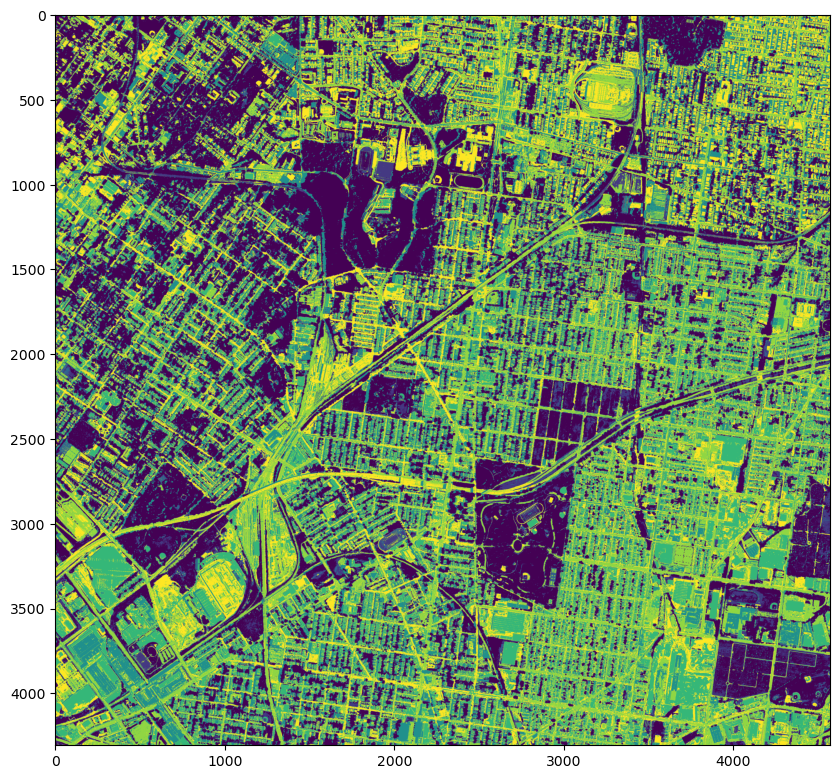

In [36]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(class_prediction)

In [42]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4571,
 'height': 4307,
 'count': 4,
 'crs': CRS.from_epsg(2272),
 'transform': Affine(3.282111922992824, 0.0, 2689280.5058,
        0.0, -3.28211191084281, 269936.0829)}

In [43]:
meta.update({"count": 1})

In [44]:
# Save the Classified Map as a GeoTIFF
output_path = "classified_lulc.tif"
with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(class_prediction, 1)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an SVM Classifier (RBF Kernel for non-linear decision boundaries)
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))